# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your interests.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [6]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
for rate in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        loss_hist = svm.train(X_train_feats, y_train, learning_rate=rate, reg=reg,
                      num_iters=1500, verbose=True)
        train_acc = np.mean(y_train == svm.predict(X_train_feats))
        val_acc = np.mean(y_val == svm.predict(X_val_feats))
        results[(rate, reg)] = (train_acc, val_acc)
        if val_acc > best_val:
            best_val = val_acc
            best_svm = svm

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 86.599795
iteration 100 / 1500: loss 85.055633
iteration 200 / 1500: loss 83.554133
iteration 300 / 1500: loss 82.071764
iteration 400 / 1500: loss 80.626823
iteration 500 / 1500: loss 79.204152
iteration 600 / 1500: loss 77.814909
iteration 700 / 1500: loss 76.453249
iteration 800 / 1500: loss 75.124507
iteration 900 / 1500: loss 73.794953
iteration 1000 / 1500: loss 72.529062
iteration 1100 / 1500: loss 71.261873
iteration 1200 / 1500: loss 70.028795
iteration 1300 / 1500: loss 68.832349
iteration 1400 / 1500: loss 67.643096
iteration 0 / 1500: loss 724.198883
iteration 100 / 1500: loss 594.487552
iteration 200 / 1500: loss 488.308352
iteration 300 / 1500: loss 401.389604
iteration 400 / 1500: loss 330.233922
iteration 500 / 1500: loss 271.975409
iteration 600 / 1500: loss 224.281735
iteration 700 / 1500: loss 185.241832
iteration 800 / 1500: loss 153.282148
iteration 900 / 1500: loss 127.112652
iteration 1000 / 1500: loss 105.691259
iteration 1100 / 1500: lo

In [7]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.422


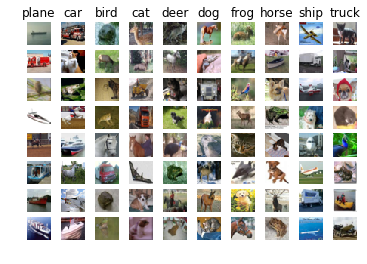

In [8]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [9]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [38]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# Your code
# learning_rates = [1e-3, 1e-5, 1e-7]
# regularization_strengths = [0.1, 10, 100]
# learning_rates = [1e-9, 1e-8, 1e-7]
# regularization_strengths = [5e4, 5e5, 5e6]

learning_rates = [0.5, 0.6, 0.75] # np.logspace(-10, 0, 5) 
regularization_strengths = [0.01, 0.05] # np.logspace(-3, 5, 5) 

hidden_sizes = [512]
num_iters_list = [2000]
best_val = 0
best_stats = None
results = {}
hyperparams = np.array(np.meshgrid(learning_rates, regularization_strengths, hidden_sizes, num_iters_list)).T.reshape(-1, 4)
for lr,reg,hs,ni in hyperparams:
    net = TwoLayerNet(input_dim, int(hs), num_classes)
    # Train the network
    stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                num_iters=int(ni), batch_size=200,
                learning_rate=lr, learning_rate_decay=0.95,
                reg=reg, verbose=False)
    train_acc = np.mean(y_train == net.predict(X_train_feats))
    val_acc = np.mean(y_val == net.predict(X_val_feats))
    results[(lr,reg,hs,ni)] = stats
    if val_acc > best_val:
        best_val = val_acc
        best_net = net
        best_stats = stats
        print("Best val acc = ", val_acc, lr,reg,hs,ni)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

Best val acc =  0.521 0.5 0.01 512.0 2000.0
Best val acc =  0.531 0.75 0.01 512.0 2000.0


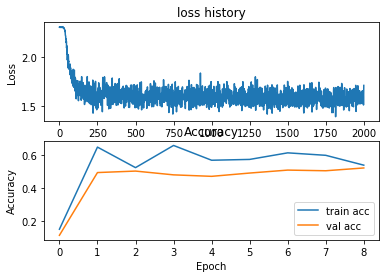

In [37]:
plt.subplot(2, 1, 1)
plt.plot(best_stats['loss_history'])
plt.title('loss history')
plt.xlabel("Iteration")
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(best_stats['train_acc_history'], label='train acc')
plt.plot(best_stats['val_acc_history'], label='val acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [17]:
# Print out results.
for lr,reg,hs,ni in sorted(results):
    stats = results[(lr,reg,hs,ni)]
    print('lr %e reg %e hs %d ni %d train ac: %.3f val ac: %.3f' % (
                lr, reg, hs, ni, stats['train_acc_history'][-1], stats['val_acc_history'][-1]))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)


lr 1.000000e-07 reg 1.000000e-02 hs 128 ni 500 train ac: 0.160 val ac: 0.102
lr 1.000000e-07 reg 1.000000e-02 hs 128 ni 1000 train ac: 0.115 val ac: 0.119
lr 1.000000e-07 reg 1.000000e-02 hs 128 ni 2000 train ac: 0.085 val ac: 0.095
lr 1.000000e-07 reg 1.000000e-02 hs 500 ni 500 train ac: 0.080 val ac: 0.116
lr 1.000000e-07 reg 1.000000e-02 hs 500 ni 1000 train ac: 0.100 val ac: 0.104
lr 1.000000e-07 reg 1.000000e-02 hs 500 ni 2000 train ac: 0.075 val ac: 0.097
lr 1.000000e-07 reg 1.000000e-02 hs 1024 ni 500 train ac: 0.125 val ac: 0.123
lr 1.000000e-07 reg 1.000000e-02 hs 1024 ni 1000 train ac: 0.110 val ac: 0.121
lr 1.000000e-07 reg 1.000000e-02 hs 1024 ni 2000 train ac: 0.105 val ac: 0.102
lr 1.000000e-07 reg 2.500000e-01 hs 128 ni 500 train ac: 0.070 val ac: 0.097
lr 1.000000e-07 reg 2.500000e-01 hs 128 ni 1000 train ac: 0.050 val ac: 0.074
lr 1.000000e-07 reg 2.500000e-01 hs 128 ni 2000 train ac: 0.070 val ac: 0.098
lr 1.000000e-07 reg 2.500000e-01 hs 500 ni 500 train ac: 0.075 va

In [30]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.528
